In [1]:
# loading libs
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading images
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 700
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

# resize
nevus_imgs = [cv2.resize(img,(256,256)) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(256,256)) for img in melanoma_imgs]

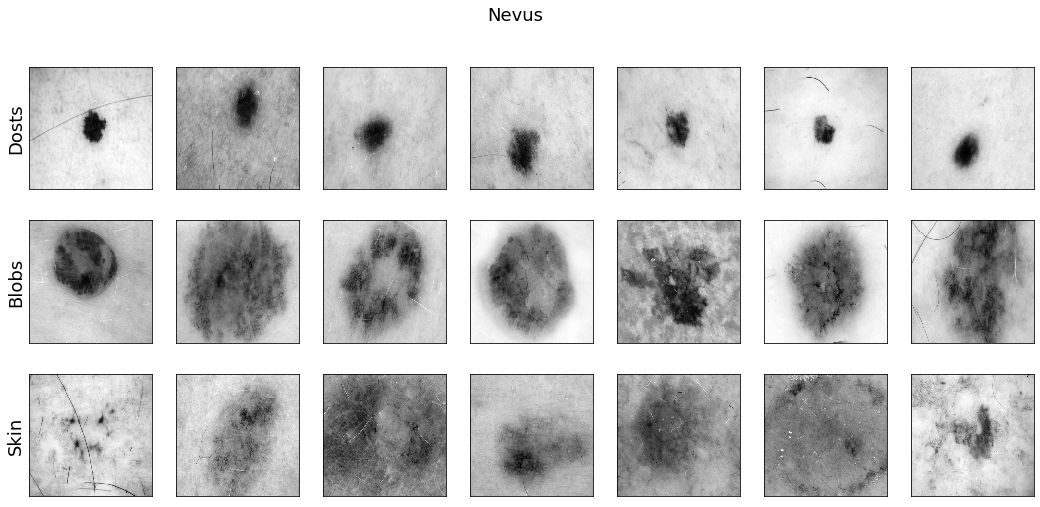

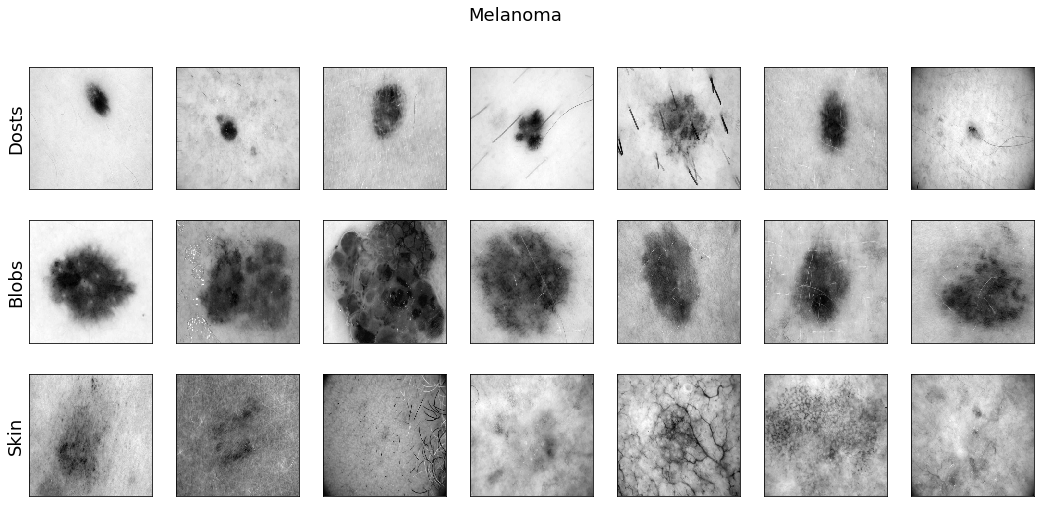

In [3]:
# Plot defenetly different types of data
# defenetly dots, blobs, skin for nevus
n_dots =  [13,19,33,35,43,63,89]
n_blobs = [0, 1, 3, 7, 20,28,34]
n_skin =  [11,27,44,50,52,68,55]

# defenetly dots, blobs, skin for melanoma
m_dots =  [6,8,15,16,29,34,46]
m_blobs = [1,3,7, 10,11,21,41]
m_skin =  [4,5,9, 13,14,26,40]

# plot
def dot_blobs_skin_plot(dots,blobs,skin,imgs,title=''):
    N = 7
    fig, ax = plt.subplots(3,N, figsize=(18,8))
    for i in range(N):
        ax[0,i].imshow(imgs[dots[i]], 'gray')
        ax[0,i].set_yticks([])
        ax[0,i].set_xticks([])
    ax[0,0].set_ylabel('Dosts', size=18)
    for i in range(N):
        ax[1,i].imshow(imgs[blobs[i]], 'gray')
        ax[1,i].set_yticks([])
        ax[1,i].set_xticks([])
    ax[1,0].set_ylabel('Blobs', size=18)
    for i in range(N):
        ax[2,i].imshow(imgs[skin[i]], 'gray')
        ax[2,i].set_yticks([])
        ax[2,i].set_xticks([])
    ax[2,0].set_ylabel('Skin', size=18)
    fig.suptitle(title, size=18)


dot_blobs_skin_plot(n_dots,n_blobs,n_skin,nevus_imgs, 'Nevus')
dot_blobs_skin_plot(m_dots,m_blobs,m_skin,melanoma_imgs, 'Melanoma')


In [4]:
# Define clustering of colors in image
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def cluster_image(img, n_colors):
    if img.max() > 1:
        img = img / 255
        
    image_array = img.reshape(img.shape[0]*img.shape[1],1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [ ]:
'''
make clustered images. For SMALL TEST data
'''
n_colors = 3
nc_imgs = []

for i in n_dots+n_blobs+n_skin:
    nc_img = cluster_image(nevus_imgs[i], n_colors)
    nc_imgs += [nc_img]
    
mc_imgs = []
for i in m_dots+m_blobs+m_skin:
    mc_img = cluster_image(melanoma_imgs[i], n_colors)
    mc_imgs += [mc_img]

In [5]:
'''
make clustered images. For BIG data
'''
n_colors = 3
nc_imgs = []

for img in nevus_imgs:
    nc_img = cluster_image(img, n_colors)
    nc_imgs += [nc_img]
    
mc_imgs = []
for img in melanoma_imgs:
    mc_img = cluster_image(img, n_colors)
    mc_imgs += [mc_img]

In [ ]:
def plot_c_imgs(c_imgs):
    N = 7
    fig, ax = plt.subplots(3,N, figsize=(18,8))
    for i in range(N):
        ax[0,i].imshow(c_imgs[i], 'gray')
        ax[0,i].set_yticks([])
        ax[0,i].set_xticks([])
    ax[0,0].set_ylabel('Dosts', size=18)
    for i in range(N):
        ax[1,i].imshow(c_imgs[7+i], 'gray')
        ax[1,i].set_yticks([])
        ax[1,i].set_xticks([])
    ax[1,0].set_ylabel('Blobs', size=18)
    for i in range(N):
        ax[2,i].imshow(c_imgs[14+i], 'gray')
        ax[2,i].set_yticks([])
        ax[2,i].set_xticks([])
    ax[2,0].set_ylabel('Skin', size=18)
    
# plot_c_imgs(nc_imgs)
plot_c_imgs(mc_imgs)

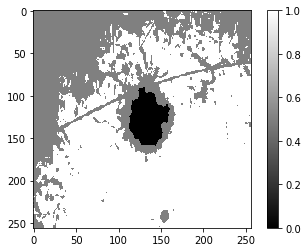

In [46]:
# Scaling all values into 3 values
def map_3color_imgs(c_imgs):
    map_val = [0, 0.5, 1]
    new_imgs = []
    for i in range(len(c_imgs)): 
        img = c_imgs[i]
        u_val = sorted(np.unique(img))
        img[img == u_val[0]] = map_val[0]
        img[img == u_val[1]] = map_val[1]
        img[img == u_val[2]] = map_val[2]

        new_imgs += [img]
    return new_imgs

n_imgs = map_3color_imgs(nc_imgs)
m_imgs = map_3color_imgs(mc_imgs)

plt.imshow(n_imgs[13], 'gray')
plt.colorbar()

In [39]:
from hilbertcurve.hilbertcurve import HilbertCurve

def get_flat_coords(a):
    # Compute HilbertCurve for 256x256 img
    p=9; N=2
    hilbert_curve = HilbertCurve(p, N)
    flat_coords = []
    for ii in range(a**2):
        coords = hilbert_curve.coordinates_from_distance(ii)
    #     print(f'coords(h={ii}) = {coords}')
        flat_coords += [coords]
    flat_coords = np.array(flat_coords)
    return flat_coords

def hilbert_flat(img, flat_coords):
    flatten_image = []
    for x,y in flat_coords:
        flatten_image += [img[x,y]]

    return np.array(flatten_image)


In [45]:
'''
Flatten images with hilbert curve
'''

fc = get_flat_coords(256)
flat_nc_imgs = [hilbert_flat(img,fc) for img in n_imgs]
flat_mc_imgs = [hilbert_flat(img,fc) for img in m_imgs]

# flat_c_imgs = [img.flatten() for img in n_imgs]

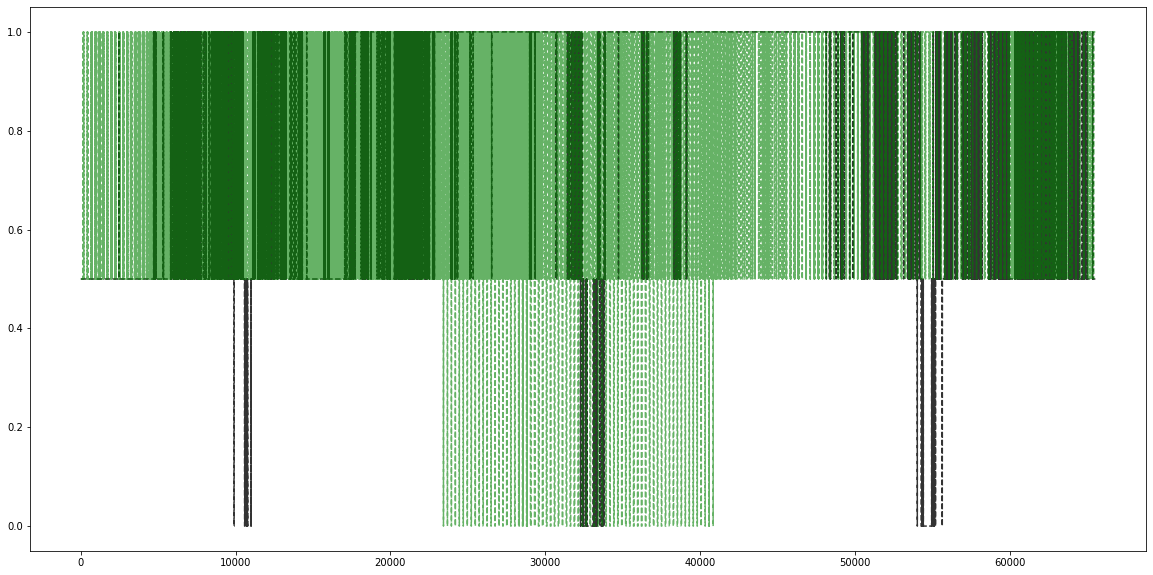

In [77]:
plt.figure(figsize=(20,10))
plt.plot(flat_nc_imgs[13], '--k', alpha=0.8)

plt.plot(n_imgs[13].flatten(), '--g', alpha=0.6)

In [80]:
from sklearn.decomposition import PCA

flat_all = flat_nc_imgs + flat_mc_imgs

# plt.figure(figsize=(10,10))
# plt.plot(fc[:,0], fc[:,1])

pca = PCA(n_components=3).fit(flat_all)
reduced_data = pca.transform(flat_all)


In [81]:
import plotly.graph_objects as go
N = 7

dots = go.Scatter3d(x=reduced_data[:,0], y=reduced_data[:,1], z=reduced_data[:,2], 
                    mode='markers', name='dots', 
                    marker=dict(
                        color='rgb(200,100,100)',
                        size=8,
                        opacity=0.9))

# blobs = go.Scatter3d(x=reduced_data[N:N*2,0], y=reduced_data[N:N*2,1], z=reduced_data[N:N*2,2], 
#                     mode='markers', name='blobs', 
#                     marker=dict(
#                         color='rgb(100,200,100)',
#                         size=8,
#                         opacity=0.9))

# skin = go.Scatter3d(x=reduced_data[N*2:,0], y=reduced_data[N*2:,1], z=reduced_data[N*2:,2], 
#                     mode='markers', name='skin', 
#                     marker=dict(
#                         color='rgb(100,100,200)',
#                         size=8,
#                         opacity=0.9))

fig = go.Figure(data=[dots])
fig.show()

In [15]:
from sklearn.cluster import KMeans

# kmeans = KMeans(init='k-means++', n_clusters=3, n_init=20, random_state=0)
# kmeans.fit(flat_c_imgs)
# Z = kmeans.predict(flat_c_imgs)



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [24]:
import pandas as pd
from sklearn.cluster import SpectralClustering 
from scipy.spatial.distance import euclidean, pdist, squareform

def similarity(u,v):
    return 1/(1+euclidean(u,v))

data = pd.DataFrame(np.array(flat_c_imgs))

dists = pdist(data, similarity)
DF_euclid = pd.DataFrame(squareform(dists), columns=data.index, index=data.index)

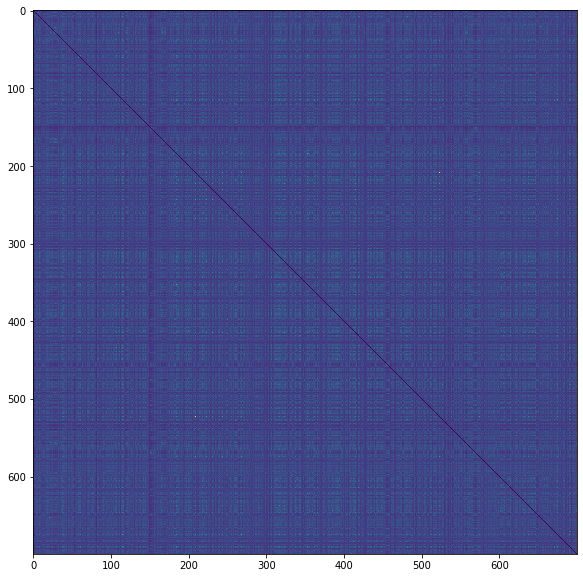

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(DF_euclid)

In [30]:
sc = SpectralClustering(n_clusters=5, random_state=0, affinity='precomputed', n_init=100)
sc.fit(DF_euclid)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=5, n_components=None,
                   n_init=100, n_jobs=None, n_neighbors=10, random_state=0)

In [32]:
fit_data = data[np.argsort(sc.row_labels_)]
fit_data = fit_data[:, np.argsort(sc.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)

AttributeError: 'SpectralClustering' object has no attribute 'row_labels_'

In [ ]:
'''
check k-means results
'''
cls_imgs = [[],[],[]]

for i in range(len(Z)):
    if Z[i] == 0:
        cls_imgs[0] += [n_imgs[i]]
    if Z[i] == 1:
        cls_imgs[1] += [n_imgs[i]]
    if Z[i] == 2:
        cls_imgs[2] += [n_imgs[i]]
        


In [ ]:
k = 0

fig, ax = plt.subplots(10,10, figsize=(16,16))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(cls_imgs[0][k],'gray')
        ax[i,j].axis('off')
        k+=1

# ALL DATA

In [ ]:
n_colors = 3
c_imgs = []

for img in nevus_imgs:
    c_img = cluster_image(img, n_colors)
    c_imgs += [c_img]

len(c_imgs)

In [ ]:
fc = get_flat_coords()
flat_c_imgs = [hilbert_flat(img,fc) for img in c_imgs]

pca = PCA(n_components=3).fit(flat_c_imgs)
reduced_data = pca.transform(flat_c_imgs)

In [ ]:
import plotly.graph_objects as go
N = 7

dots = go.Scatter3d(x=reduced_data[:,0], y=reduced_data[:,1], z=reduced_data[:,2], mode='markers')

fig = go.Figure(data=[dots])
fig.show()

# Plot redused dimantion dataset

In [ ]:
all_imgs = melanoma_imgs+nevus_imgs

In [ ]:
# Data feature extruction
def compute_fft(img):
    fft = np.fft.fft2(img)
    return np.fft.fftshift(fft).real
    
feature_data = [compute_fft(img) for img in all_imgs]

In [ ]:
from sklearn.decomposition import PCA
data = all_imgs

flat_c_imgs = [img.flatten()/255 for img in data]

pca = PCA(n_components=3).fit(flat_c_imgs)
reduced_data = pca.transform(flat_c_imgs)

In [82]:
from sklearn.manifold import TSNE
embedded = TSNE(n_components=3, n_jobs=-1).fit_transform(flat_all)

In [83]:
import plotly.graph_objects as go
data = reduced_data

n = go.Scatter3d(x=data[:700,0], y=data[:700,1], z=data[:700,2], 
                 mode='markers',
                 name='nevus',
                 marker=dict(
                     color='rgb(255,169,34)',
                     size=3,
                     opacity=0.8))

m = go.Scatter3d(x=data[700:,0], y=data[700:,1], z=data[700:,2], 
                 mode='markers',
                 name='melanomas',
                 marker=dict(
                     color='rgb(83,97,255)',
                     size=3,
                     opacity=0.8))

fig = go.Figure(data=[n,m])
fig.update_layout(
    title_text='3D projection',
    height=800,
    width=800
)
fig.show()

In [ ]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = np.array(flat_c_imgs) 
y = np.zeros(len(flat_c_imgs))
y[:700] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=300, random_state=0).fit(X_train, y_train)

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(1 - (y_test != y_pred).sum() / X_test.shape[0])

In [ ]:
# XGBoost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic'}
num_round = 10

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)

In [ ]:
np.sum(np.round(preds) == y_test) / len(y_test)

# CNN to 3color dataset

In [85]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [87]:
# My model
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(64,(4,4), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 81, 81, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0         
_______________________________________

In [93]:
X_train = np.array([img.reshape(256,256,1) for img in n_imgs+m_imgs])
y_train = np.zeros(X_train.shape[0])
y_train[:700] = 1

In [96]:
history = model.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_split=0.2)

Train on 1120 samples, validate on 280 samples
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1/20
1120/1120 [==============================] - 3s 3ms/sample - loss: 0.0265 - acc: 0.9714 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/20
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/20
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/20
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/20
1120/1120 [==============================] - 1s 1ms/sample - loss: 0.0

(1400,)